# 2018-05-25 - Réseau convolutionnel simple avec Binary Cross Entropy Loss

On utilise les images en 64x64 et on définit un réseau convolutionnel simple (CNN+MaxPool+Linéaire) :

In [5]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch 
import torchvision
from torchvision import transforms, datasets

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=4, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=4,shuffle=False,
                                             num_workers=1)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 15)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(10000, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80,16)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = self.sigm(x)
        return x

model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(15, 15), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (fc1): Linear(in_features=10000, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=16, bias=True)
  (sigm): Sigmoid()
)


On défini le BCE et on entraine :

In [10]:
#PyTorch has no one-hot encoder =(
def one_hot_v3(batch,depth):
    emb = nn.Embedding(depth, depth)
    emb.weight.data = torch.eye(depth)
    return emb(batch)

#Params
epochs = 5

#Optimizer
import torch.optim as optim
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

total_step = len(train_loader)
loss_list = []
time_list = []
t=0

import time
start_time = time.time()
print("Started training")

for epoch in range(epochs) :
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
        #print(images.size())
        #print(labels.size())
        labels = one_hot_v3(labels, 16)
        
        # Forward pass
        outputs = model(images)
        #print(outputs.size())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

Started training
Epoch [1/5], Step [100/960], Loss: 0.7210
Epoch [1/5], Step [200/960], Loss: 0.7016
Epoch [1/5], Step [300/960], Loss: 0.7010
Epoch [1/5], Step [400/960], Loss: 0.6948
Epoch [1/5], Step [500/960], Loss: 0.6934


Process Process-11:
Traceback (most recent call last):
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
Exception ignored in: <bou

KeyboardInterrupt: 

Et maintenant on teste :

Test Accuracy of the model on the test images: 6.25 %


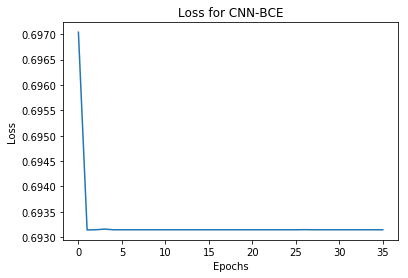

In [4]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    labels = Variable(labels)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for CNN-BCE')
plt.show()